In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers


In [2]:
def error_rate(label, prediction, ft_len, forecast_len):
    error_avg = 0
    ft_len = ft_len-1
    for i in range(forecast_len):
        error = abs((label[ft_len+i,0,0] - prediction[ft_len,i,0])/label[ft_len+i,0,0] * 100)
        print('num',i,error,'actual',label[ft_len+i,0,0],'prediction',predictions[ft_len,i,0])
        error_avg = error_avg + error
    error_avg = error_avg/forecast_len
    return error_avg

In [3]:
def kalman_filter(z_meas, x_esti, P):
    """Kalman Filter Algorithm for One Variable."""
    # (1) Prediction.
    x_pred = A * x_esti
    P_pred = A * P * A + Q

    # (2) Kalman Gain.
    K = P_pred * H / (H * P_pred * H + R)

    # (3) Estimation.
    x_esti = x_pred + K * (z_meas - H * x_pred)

    # (4) Error Covariance.
    P = P_pred - K * H * P_pred

    return x_esti, P

In [4]:

# Initialization for system model.
A = 1
H = 1
Q = 0.1
R = 7
# Initialization for estimation.
x_0 = 10  # 14 for book.
P_0 = 6

In [5]:
forecasting = 20

In [6]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [7]:
df = df['Resistance']
df

0      0.259
1      0.260
2      0.259
3      0.259
4      0.259
       ...  
254    0.301
255    0.301
256    0.302
257    0.300
258    0.296
Name: Resistance, Length: 259, dtype: float64

<AxesSubplot:>

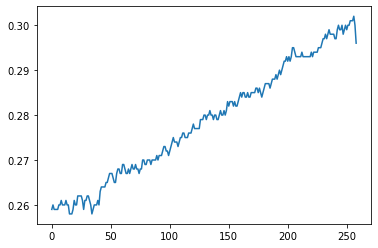

In [8]:
df.plot()

In [9]:
n_samples = len(df)
x_0 = df[1]
r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = df[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

df = r_esti_save

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Resistance']
df = pd.DataFrame(df)
df.columns = scale_cols
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(type(df_scaled))

<class 'pandas.core.frame.DataFrame'>


In [11]:
train = df_scaled

In [12]:
def make_dataset(data, label, window_size=forecasting):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [13]:
feature_cols = ['Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, forecasting)
total_len = len(train_feature)

x_train = train_feature[:int(total_len*0.8)]
x_valid = train_feature[int(total_len*0.8):]
y_train = train_label[:int(total_len*0.8)]
y_valid = train_label[int(total_len*0.8):]

In [14]:
x_train.shape

(191, 20, 1)

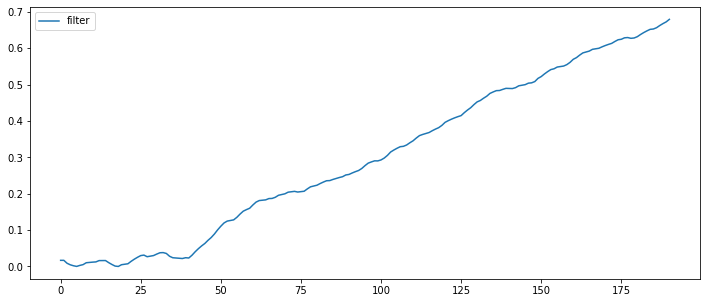

In [15]:
plt.figure(figsize=(12,5))
plt.plot(x_train[:,0,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

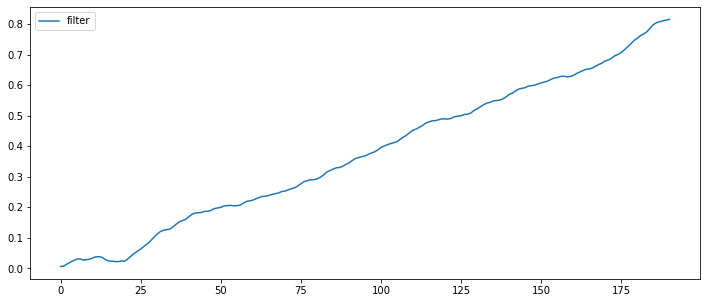

In [16]:
y_train.shape
plt.figure(figsize=(12,5))
plt.plot(y_train[:,0],label="filter")
# plt.ylim(0,1)
plt.legend()
plt.show()

In [17]:
OUT_STEPS = 20

In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.GRU(30, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(tf.keras.layers.Dense(OUT_STEPS*1))
model.add(tf.keras.layers.Reshape([OUT_STEPS, 1]))

In [19]:
model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(lr=0.001), metrics=[tf.metrics.MeanAbsoluteError()])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('models/', 'kjgreftmp_checkpoint.h5')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, x_train, 
                    epochs=1000, 
                    batch_size=16)

Epoch 1/1000
12/12 [==============================] - 2s 6ms/step - loss: 0.1488 - mean_absolute_error: 0.3090
Epoch 2/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.1158 - mean_absolute_error: 0.2713
Epoch 3/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.1057 - mean_absolute_error: 0.2587
Epoch 4/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0757 - mean_absolute_error: 0.2110
Epoch 5/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0557 - mean_absolute_error: 0.1800
Epoch 6/1000
12/12 [==============================] - 0s 6ms/step - loss: 0.0340 - mean_absolute_error: 0.1393
Epoch 7/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0227 - mean_absolute_error: 0.1126
Epoch 8/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0115 - mean_absolute_error: 0.0800
Epoch 9/1000
12/12 [==============================] - 0s 5ms/step - loss: 0.0050 - mean_absolute_error: 0.0517
E

12/12 [==============================] - 0s 5ms/step - loss: 1.3564e-04 - mean_absolute_error: 0.0089
Epoch 73/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.2894e-04 - mean_absolute_error: 0.0085
Epoch 74/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.1866e-04 - mean_absolute_error: 0.0083
Epoch 75/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.5334e-04 - mean_absolute_error: 0.0093
Epoch 76/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.1896e-04 - mean_absolute_error: 0.0081
Epoch 77/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.1226e-04 - mean_absolute_error: 0.0080
Epoch 78/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.2407e-04 - mean_absolute_error: 0.0085
Epoch 79/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.2638e-04 - mean_absolute_error: 0.0084
Epoch 80/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.1180e-04 

12/12 [==============================] - 0s 4ms/step - loss: 9.7577e-05 - mean_absolute_error: 0.0075
Epoch 143/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.0856e-04 - mean_absolute_error: 0.0079
Epoch 144/1000
12/12 [==============================] - 0s 4ms/step - loss: 9.9877e-05 - mean_absolute_error: 0.0076
Epoch 145/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.0791e-04 - mean_absolute_error: 0.0079
Epoch 146/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.0507e-04 - mean_absolute_error: 0.0078
Epoch 147/1000
12/12 [==============================] - 0s 4ms/step - loss: 9.3755e-05 - mean_absolute_error: 0.0072
Epoch 148/1000
12/12 [==============================] - 0s 4ms/step - loss: 9.6247e-05 - mean_absolute_error: 0.0074
Epoch 149/1000
12/12 [==============================] - 0s 5ms/step - loss: 9.8562e-05 - mean_absolute_error: 0.0074
Epoch 150/1000
12/12 [==============================] - 0s 5ms/step - loss: 8.3

12/12 [==============================] - 0s 5ms/step - loss: 8.7312e-05 - mean_absolute_error: 0.0071
Epoch 213/1000
12/12 [==============================] - 0s 4ms/step - loss: 8.4407e-05 - mean_absolute_error: 0.0071
Epoch 214/1000
12/12 [==============================] - 0s 5ms/step - loss: 9.3063e-05 - mean_absolute_error: 0.0074
Epoch 215/1000
12/12 [==============================] - 0s 5ms/step - loss: 9.0865e-05 - mean_absolute_error: 0.0074
Epoch 216/1000
12/12 [==============================] - 0s 5ms/step - loss: 9.1111e-05 - mean_absolute_error: 0.0073
Epoch 217/1000
12/12 [==============================] - 0s 4ms/step - loss: 7.7587e-05 - mean_absolute_error: 0.0067
Epoch 218/1000
12/12 [==============================] - 0s 4ms/step - loss: 8.1985e-05 - mean_absolute_error: 0.0070
Epoch 219/1000
12/12 [==============================] - 0s 5ms/step - loss: 8.8504e-05 - mean_absolute_error: 0.0072
Epoch 220/1000
12/12 [==============================] - 0s 5ms/step - loss: 8.1

12/12 [==============================] - 0s 5ms/step - loss: 6.3266e-05 - mean_absolute_error: 0.0061
Epoch 283/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.7374e-05 - mean_absolute_error: 0.0064
Epoch 284/1000
12/12 [==============================] - 0s 5ms/step - loss: 6.9691e-05 - mean_absolute_error: 0.0066
Epoch 285/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.4338e-05 - mean_absolute_error: 0.0062
Epoch 286/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.9781e-05 - mean_absolute_error: 0.0065
Epoch 287/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.4705e-05 - mean_absolute_error: 0.0063
Epoch 288/1000
12/12 [==============================] - 0s 4ms/step - loss: 7.4851e-05 - mean_absolute_error: 0.0068
Epoch 289/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.5788e-05 - mean_absolute_error: 0.0064
Epoch 290/1000
12/12 [==============================] - 0s 5ms/step - loss: 6.8

12/12 [==============================] - 0s 4ms/step - loss: 6.5745e-05 - mean_absolute_error: 0.0063
Epoch 352/1000
12/12 [==============================] - 0s 5ms/step - loss: 6.5943e-05 - mean_absolute_error: 0.0064
Epoch 353/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.9834e-05 - mean_absolute_error: 0.0060
Epoch 354/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.0333e-05 - mean_absolute_error: 0.0061
Epoch 355/1000
12/12 [==============================] - 0s 4ms/step - loss: 6.0278e-05 - mean_absolute_error: 0.0061
Epoch 356/1000
12/12 [==============================] - 0s 5ms/step - loss: 5.5905e-05 - mean_absolute_error: 0.0059
Epoch 357/1000
12/12 [==============================] - 0s 5ms/step - loss: 5.5475e-05 - mean_absolute_error: 0.0059
Epoch 358/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.8258e-05 - mean_absolute_error: 0.0060
Epoch 359/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.5

12/12 [==============================] - 0s 5ms/step - loss: 5.0216e-05 - mean_absolute_error: 0.0055
Epoch 422/1000
12/12 [==============================] - 0s 5ms/step - loss: 5.0717e-05 - mean_absolute_error: 0.0057
Epoch 423/1000
12/12 [==============================] - 0s 5ms/step - loss: 5.3856e-05 - mean_absolute_error: 0.0058
Epoch 424/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.4735e-05 - mean_absolute_error: 0.0058
Epoch 425/1000
12/12 [==============================] - 0s 5ms/step - loss: 5.3494e-05 - mean_absolute_error: 0.0058
Epoch 426/1000
12/12 [==============================] - 0s 5ms/step - loss: 5.6218e-05 - mean_absolute_error: 0.0060
Epoch 427/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.3004e-05 - mean_absolute_error: 0.0058
Epoch 428/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.9605e-05 - mean_absolute_error: 0.0055
Epoch 429/1000
12/12 [==============================] - 0s 4ms/step - loss: 5.1

12/12 [==============================] - 0s 5ms/step - loss: 5.5887e-05 - mean_absolute_error: 0.0059
Epoch 492/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.9537e-05 - mean_absolute_error: 0.0057
Epoch 493/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.3842e-05 - mean_absolute_error: 0.0052
Epoch 494/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.2343e-05 - mean_absolute_error: 0.0051
Epoch 495/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.5142e-05 - mean_absolute_error: 0.0052
Epoch 496/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.8126e-05 - mean_absolute_error: 0.0055
Epoch 497/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.7651e-05 - mean_absolute_error: 0.0055A: 0s - loss: 4.7807e-05 - mean_absolute_error: 0.005
Epoch 498/1000
12/12 [==============================] - 0s 4ms/step - loss: 4.9724e-05 - mean_absolute_error: 0.0056
Epoch 499/1000
12/12 [====

12/12 [==============================] - 0s 4ms/step - loss: 3.5941e-05 - mean_absolute_error: 0.0047
Epoch 561/1000
12/12 [==============================] - 0s 5ms/step - loss: 4.0669e-05 - mean_absolute_error: 0.0050
Epoch 562/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.6927e-05 - mean_absolute_error: 0.0048
Epoch 563/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.7773e-05 - mean_absolute_error: 0.0049
Epoch 564/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.7393e-05 - mean_absolute_error: 0.0048
Epoch 565/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.7410e-05 - mean_absolute_error: 0.0048
Epoch 566/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.4054e-05 - mean_absolute_error: 0.0045
Epoch 567/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.4502e-05 - mean_absolute_error: 0.0046
Epoch 568/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.5

12/12 [==============================] - 0s 5ms/step - loss: 3.0690e-05 - mean_absolute_error: 0.0043
Epoch 631/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.8927e-05 - mean_absolute_error: 0.0042
Epoch 632/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.2265e-05 - mean_absolute_error: 0.0045
Epoch 633/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0513e-05 - mean_absolute_error: 0.0043
Epoch 634/1000
12/12 [==============================] - 0s 4ms/step - loss: 3.5073e-05 - mean_absolute_error: 0.0047
Epoch 635/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0612e-05 - mean_absolute_error: 0.0043
Epoch 636/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0683e-05 - mean_absolute_error: 0.0043
Epoch 637/1000
12/12 [==============================] - 0s 5ms/step - loss: 3.0044e-05 - mean_absolute_error: 0.0043
Epoch 638/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.9

12/12 [==============================] - 0s 4ms/step - loss: 2.6801e-05 - mean_absolute_error: 0.0041
Epoch 700/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7236e-05 - mean_absolute_error: 0.0041
Epoch 701/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.6528e-05 - mean_absolute_error: 0.0040
Epoch 702/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.6758e-05 - mean_absolute_error: 0.0040
Epoch 703/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.4100e-05 - mean_absolute_error: 0.0038
Epoch 704/1000
12/12 [==============================] - ETA: 0s - loss: 2.0506e-05 - mean_absolute_error: 0.003 - 0s 4ms/step - loss: 2.4890e-05 - mean_absolute_error: 0.0039
Epoch 705/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.7112e-05 - mean_absolute_error: 0.0041
Epoch 706/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.6952e-05 - mean_absolute_error: 0.0040
Epoch 707/1000
12/12 

12/12 [==============================] - 0s 4ms/step - loss: 2.1788e-05 - mean_absolute_error: 0.0036
Epoch 769/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.1976e-05 - mean_absolute_error: 0.0036
Epoch 770/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.4491e-05 - mean_absolute_error: 0.0039
Epoch 771/1000
12/12 [==============================] - 0s 7ms/step - loss: 2.5651e-05 - mean_absolute_error: 0.0039
Epoch 772/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.3917e-05 - mean_absolute_error: 0.0038
Epoch 773/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.6795e-05 - mean_absolute_error: 0.0041
Epoch 774/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.3866e-05 - mean_absolute_error: 0.0038
Epoch 775/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.3787e-05 - mean_absolute_error: 0.0038
Epoch 776/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.1

12/12 [==============================] - 0s 4ms/step - loss: 2.2412e-05 - mean_absolute_error: 0.0037
Epoch 838/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.1018e-05 - mean_absolute_error: 0.0036
Epoch 839/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.1755e-05 - mean_absolute_error: 0.0036
Epoch 840/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.1999e-05 - mean_absolute_error: 0.0037
Epoch 841/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.1214e-05 - mean_absolute_error: 0.0036
Epoch 842/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.2870e-05 - mean_absolute_error: 0.0037
Epoch 843/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.0788e-05 - mean_absolute_error: 0.0035
Epoch 844/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.9107e-05 - mean_absolute_error: 0.0034
Epoch 845/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.0

12/12 [==============================] - 0s 4ms/step - loss: 2.6859e-05 - mean_absolute_error: 0.0041
Epoch 907/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.2636e-05 - mean_absolute_error: 0.0037
Epoch 908/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.1973e-05 - mean_absolute_error: 0.0036
Epoch 909/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.0820e-05 - mean_absolute_error: 0.0036
Epoch 910/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.1371e-05 - mean_absolute_error: 0.0036
Epoch 911/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.8876e-05 - mean_absolute_error: 0.0034
Epoch 912/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.0306e-05 - mean_absolute_error: 0.0035
Epoch 913/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.8779e-05 - mean_absolute_error: 0.0034
Epoch 914/1000
12/12 [==============================] - 0s 4ms/step - loss: 1.9

12/12 [==============================] - 0s 5ms/step - loss: 2.1447e-05 - mean_absolute_error: 0.0036
Epoch 977/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.1640e-05 - mean_absolute_error: 0.0037
Epoch 978/1000
12/12 [==============================] - 0s 4ms/step - loss: 2.2733e-05 - mean_absolute_error: 0.0038
Epoch 979/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.3416e-05 - mean_absolute_error: 0.0038
Epoch 980/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.9948e-05 - mean_absolute_error: 0.0035
Epoch 981/1000
12/12 [==============================] - 0s 5ms/step - loss: 2.0393e-05 - mean_absolute_error: 0.0035
Epoch 982/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.9241e-05 - mean_absolute_error: 0.0034
Epoch 983/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.8194e-05 - mean_absolute_error: 0.0033
Epoch 984/1000
12/12 [==============================] - 0s 5ms/step - loss: 1.9

num 0 21.46166746432973 actual 0.6190476190476186 prediction 0.75190556
num 1 12.289410829544167 actual 0.6666666666666661 prediction 0.7485961
num 2 5.882196426391714 actual 0.7142857142857135 prediction 0.7563014
num 3 0.6409335881470517 actual 0.7619047619047628 prediction 0.76678807
num 4 8.598054647445794 actual 0.7142857142857135 prediction 0.7757004
num 5 16.0552591085435 actual 0.6666666666666661 prediction 0.7737017
num 6 17.53245890140544 actual 0.6666666666666661 prediction 0.7835497
num 7 18.899151682853805 actual 0.6666666666666661 prediction 0.792661
num 8 13.061583042144894 actual 0.7142857142857135 prediction 0.80758274
num 9 13.589882850647095 actual 0.7142857142857135 prediction 0.8113563
num 10 15.360893011093262 actual 0.7142857142857135 prediction 0.8240064
num 11 24.801218509674182 actual 0.6666666666666661 prediction 0.8320081
num 12 17.517668008804446 actual 0.7142857142857135 prediction 0.8394119
num 13 11.439907178282613 actual 0.7619047619047628 prediction 0.

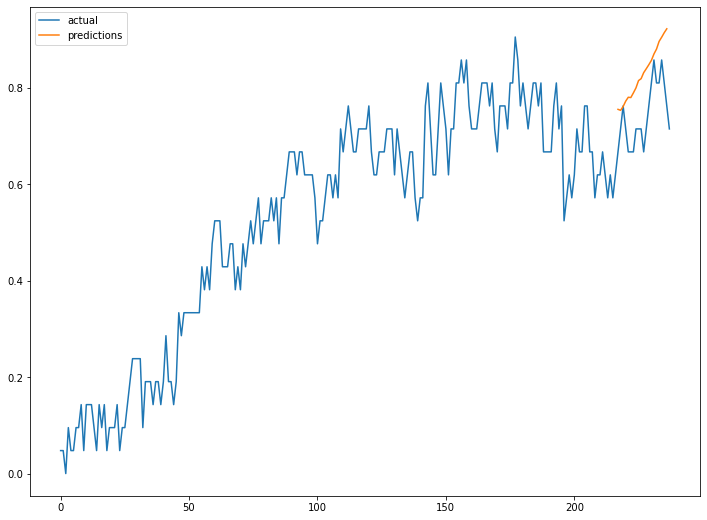

In [20]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 3.979652463173358 actual 0.8006535947712417 prediction 0.76879036
num 1 4.42315984156824 actual 0.8104575163398693 prediction 0.7746097
num 2 4.319749682782644 actual 0.8137254901960784 prediction 0.7785746
num 3 2.9617749691009503 actual 0.8169934640522876 prediction 0.79279596
num 4 2.4216664791107156 actual 0.8169934640522876 prediction 0.7972086
num 5 3.0389793365600064 actual 0.8202614379084967 prediction 0.79533386
num 6 2.378723979467454 actual 0.826797385620915 prediction 0.80713016
num 7 2.6927837170660394 actual 0.8366013071895424 prediction 0.81407344
num 8 2.5194098590423564 actual 0.8464052287581698 prediction 0.8250808
num 9 3.109028832665789 actual 0.8529411764705881 prediction 0.826423
num 10 3.1204216380536143 actual 0.8594771241830064 prediction 0.8326578
num 11 2.917551587928405 actual 0.8627450980392155 prediction 0.83757406
num 12 2.6472484840536805 actual 0.8660130718954246 prediction 0.84308755
num 13 1.94142589029274 actual 0.8660130718954246 prediction 0.

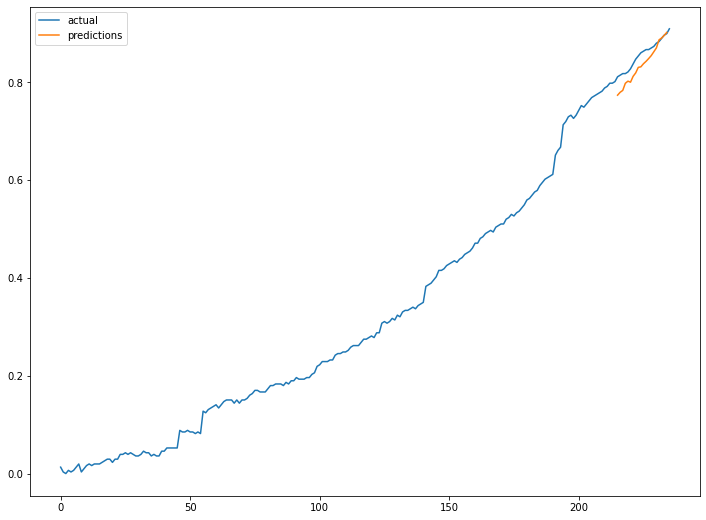

In [21]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 0.3741678814170077 actual 0.6762402088772845 prediction 0.6787705
num 1 1.1620590632611898 actual 0.6892950391644908 prediction 0.681285
num 2 1.3661492406651958 actual 0.6971279373368144 prediction 0.6876041
num 3 0.7188920416353142 actual 0.702349869451697 prediction 0.69730073
num 4 0.643470674423256 actual 0.7075718015665795 prediction 0.7030188
num 5 1.1848880209191903 actual 0.7154046997389034 prediction 0.70692796
num 6 1.578263890358706 actual 0.7284595300261096 prediction 0.7169625
num 7 1.9837135560942238 actual 0.7389033942558747 prediction 0.72424567
num 8 2.0756811007389855 actual 0.7493472584856395 prediction 0.7337932
num 9 1.8717878417572609 actual 0.7545691906005221 prediction 0.74044526
num 10 1.9968794067565003 actual 0.7650130548302871 prediction 0.74973667
num 11 1.338018770931537 actual 0.7676240208877285 prediction 0.75735307
num 12 0.5475287534752749 actual 0.7676240208877285 prediction 0.76342106
num 13 0.6896526821507564 actual 0.7780678851174934 predict

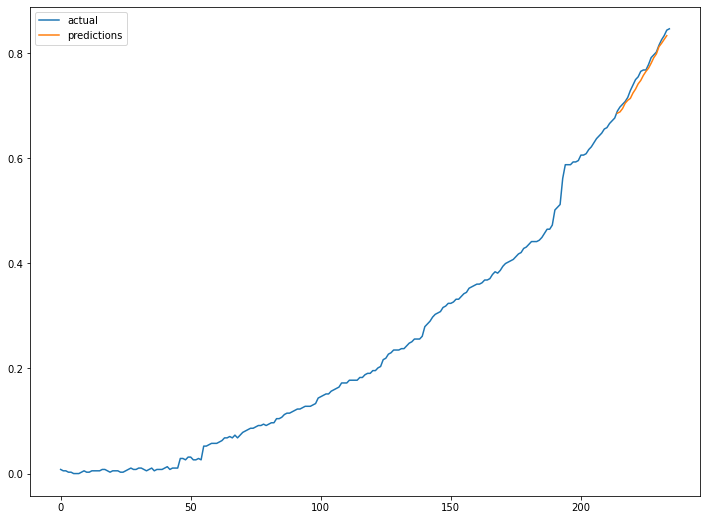

In [22]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 0.060688821892914566 actual 0.7916666666666661 prediction 0.7911862
num 1 0.5189243115877602 actual 0.7916666666666661 prediction 0.7957748
num 2 1.1835550007067985 actual 0.7916666666666661 prediction 0.8010365
num 3 8.874273300170898 actual 0.75 prediction 0.81655705
num 4 3.781265961496531 actual 0.7916666666666661 prediction 0.8216017
num 5 9.350792566935223 actual 0.75 prediction 0.82013094
num 6 0.16805887222297133 actual 0.8333333333333339 prediction 0.83193284
num 7 1.1960911750792738 actual 0.8333333333333339 prediction 0.84330076
num 8 6.298923492431579 actual 0.9166666666666661 prediction 0.85892653
num 9 10.24428035901946 actual 0.9583333333333339 prediction 0.860159
num 10 9.192201365595334 actual 0.9583333333333339 prediction 0.8702414
num 11 8.439186344976067 actual 0.9583333333333339 prediction 0.8774578
num 12 7.5133655382239874 actual 0.9583333333333339 prediction 0.88633025
num 13 6.860759983892084 actual 0.9583333333333339 prediction 0.8925844
num 14 1.1876409

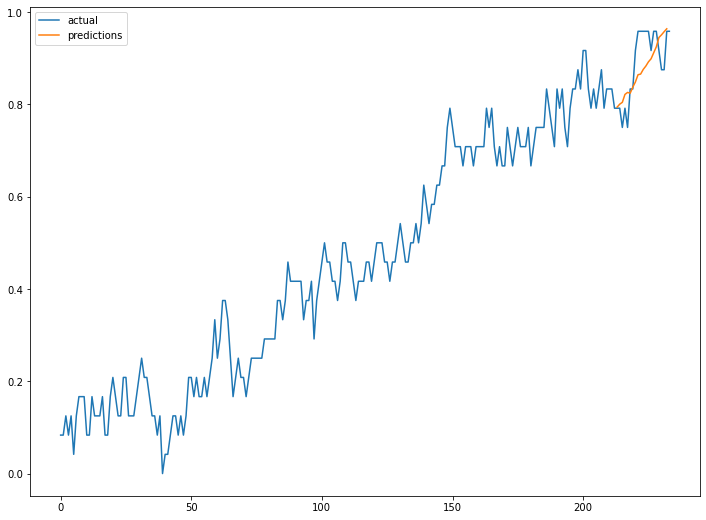

In [23]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 3.7938700224223743 actual 0.8482142857142856 prediction 0.81603414
num 1 3.8699487845102523 actual 0.8571428571428568 prediction 0.82397187
num 2 2.609491850200438 actual 0.8482142857142856 prediction 0.8260802
num 3 1.1583498011084457 actual 0.8526785714285712 prediction 0.8428016
num 4 2.217725380179787 actual 0.8660714285714284 prediction 0.84686434
num 5 3.935745784214565 actual 0.875 prediction 0.8405622
num 6 2.9009514048619787 actual 0.8794642857142856 prediction 0.85395145
num 7 3.1833179032981875 actual 0.8883928571428568 prediction 0.8601125
num 8 1.2862600461400837 actual 0.8839285714285712 prediction 0.87255895
num 9 2.0354831638048223 actual 0.8883928571428568 prediction 0.87030977
num 10 1.0568647673635487 actual 0.8839285714285712 prediction 0.87458664
num 11 1.6544713973998952 actual 0.8928571428571428 prediction 0.8780851
num 12 2.0561794243236236 actual 0.901785714285714 prediction 0.8832434
num 13 2.101233909870016 actual 0.90625 prediction 0.88720757
num 14 1.

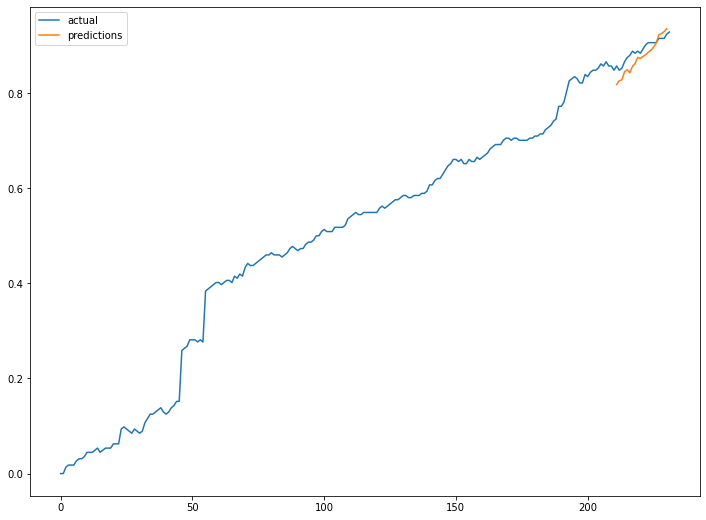

In [24]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 4.5134502298693295 actual 0.8500000000000014 prediction 0.8116357
num 1 2.607637643813996 actual 0.8000000000000007 prediction 0.8208611
num 2 9.692223866780598 actual 0.75 prediction 0.8226917
num 3 11.750189463297527 actual 0.75 prediction 0.8381264
num 4 12.180066108703613 actual 0.75 prediction 0.8413505
num 5 11.327513058980305 actual 0.75 prediction 0.83495635
num 6 21.092413152966998 actual 0.7000000000000011 prediction 0.8476469
num 7 21.57452957970737 actual 0.7000000000000011 prediction 0.8510217
num 8 32.33410395108729 actual 0.6500000000000004 prediction 0.8601717
num 9 22.39656278065254 actual 0.7000000000000011 prediction 0.85677594
num 10 14.260967572530111 actual 0.75 prediction 0.85695726
num 11 14.440488815307617 actual 0.75 prediction 0.85830367
num 12 23.001669134412307 actual 0.7000000000000011 prediction 0.8610117
num 13 23.30630847385933 actual 0.7000000000000011 prediction 0.86314416
num 14 8.221776783466243 actual 0.8000000000000007 prediction 0.8657742
n

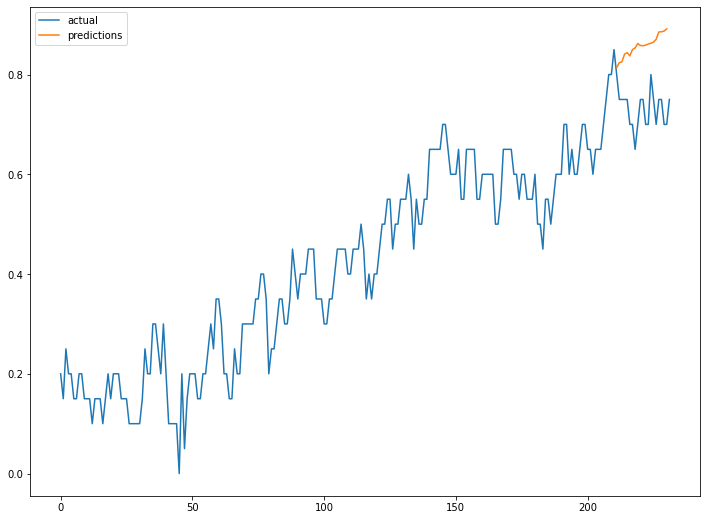

In [25]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 4.784839972853555 actual 0.8421052631578938 prediction 0.8018119
num 1 7.158736749128843 actual 0.8684210526315788 prediction 0.8062531
num 2 3.875848278403175 actual 0.8421052631578938 prediction 0.80946654
num 3 5.15614061644581 actual 0.8684210526315788 prediction 0.82364404
num 4 4.47523377158423 actual 0.8684210526315788 prediction 0.8295572
num 5 2.3270715028046474 actual 0.8421052631578938 prediction 0.8225089
num 6 2.3511682787250163 actual 0.8157894736842097 prediction 0.83497006
num 7 2.9522565103347302 actual 0.8157894736842097 prediction 0.8398737
num 8 1.1450171470643211 actual 0.8421052631578938 prediction 0.8517475
num 9 0.9462088346482443 actual 0.8421052631578938 prediction 0.85007334
num 10 1.5247998815594086 actual 0.8684210526315788 prediction 0.85517937
num 11 1.9940223544837175 actual 0.8421052631578938 prediction 0.85889703
num 12 3.5693582366494216 actual 0.8947368421052628 prediction 0.8628005
num 13 0.05902377041901258 actual 0.8684210526315788 predictio

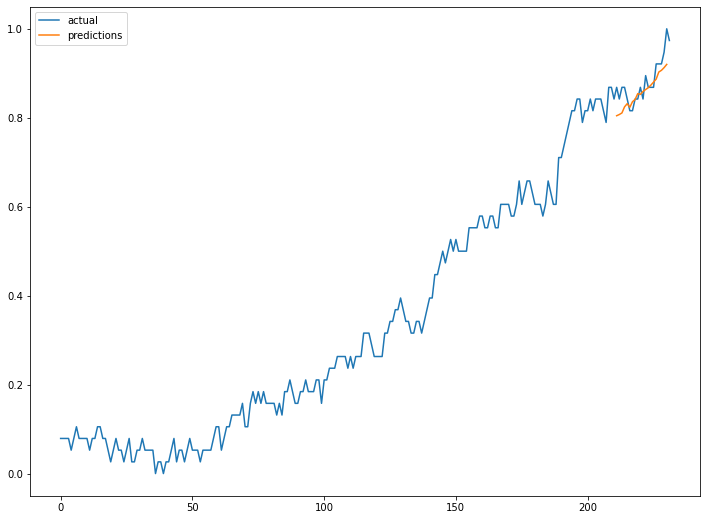

In [26]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 0.03648638725291416 actual 0.76923076923077 prediction 0.7689501
num 1 5.650059800398839 actual 0.7307692307692317 prediction 0.7720581
num 2 6.24529938948768 actual 0.7307692307692317 prediction 0.77640796
num 3 7.999354914614887 actual 0.7307692307692317 prediction 0.78922606
num 4 14.89681402842215 actual 0.6923076923076916 prediction 0.7954395
num 5 2.855067849159131 actual 0.76923076923077 prediction 0.7911928
num 6 0.5869848387582802 actual 0.8076923076923084 prediction 0.8029513
num 7 0.12528158369509992 actual 0.8076923076923084 prediction 0.8087042
num 8 3.0588870698756065 actual 0.8461538461538467 prediction 0.82027096
num 9 1.6566787447247326 actual 0.8076923076923084 prediction 0.8210732
num 10 7.684687376022224 actual 0.76923076923077 prediction 0.82834375
num 11 8.360024690627936 actual 0.76923076923077 prediction 0.83353865
num 12 8.920093774795417 actual 0.76923076923077 prediction 0.8378469
num 13 4.595000970931191 actual 0.8076923076923084 prediction 0.8448058
n

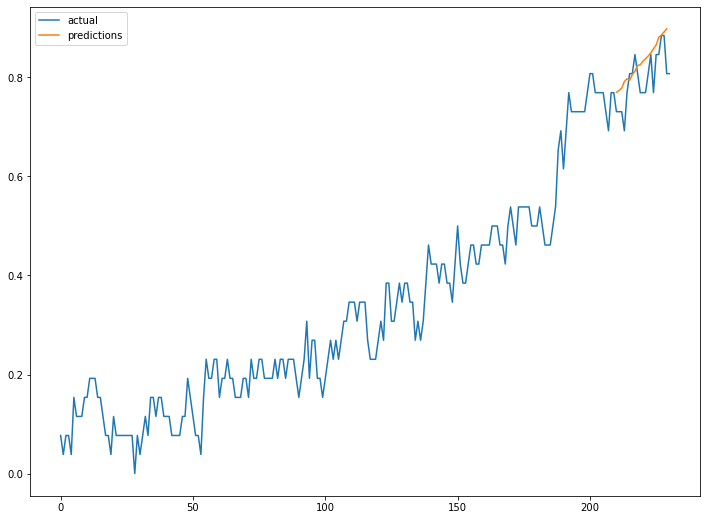

In [27]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()

num 0 0.3366119066873867 actual 0.7389162561576352 prediction 0.736429
num 1 1.0861621091240297 actual 0.7487684729064039 prediction 0.74063563
num 2 1.066357364841488 actual 0.7536945812807878 prediction 0.7456575
num 3 0.12980645353140438 actual 0.7586206896551722 prediction 0.75763595
num 4 0.7728551060725416 actual 0.7684729064039408 prediction 0.7625337
num 5 1.4178380465051998 actual 0.7733990147783252 prediction 0.76243347
num 6 0.6632627942893715 actual 0.7783251231527091 prediction 0.7731628
num 7 0.47475200779030874 actual 0.7832512315270934 prediction 0.77953273
num 8 0.13598993420601838 actual 0.7881773399014778 prediction 0.7892492
num 9 0.13035302576811802 actual 0.7931034482758621 prediction 0.7920696
num 10 0.09665419290099068 actual 0.798029556650246 prediction 0.7988009
num 11 0.7748298438979173 actual 0.798029556650246 prediction 0.8042129
num 12 0.1378262915262484 actual 0.8078817733990147 prediction 0.80899525
num 13 0.8081698489046107 actual 0.8226600985221673 pre

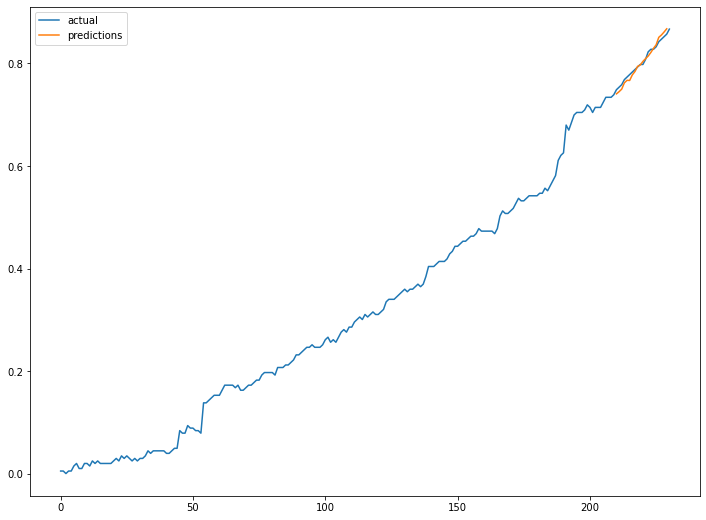

In [28]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')
x_test_no_kf = test_df['Resistance']
x_test2 = test_df['Resistance']

n_samples = len(x_test2)
x_0 = x_test2[1]

r_meas_save = np.zeros(n_samples)
r_esti_save = np.zeros(n_samples)

x_esti, P = None, None
for i in range(n_samples):
    r_meas = x_test2[i]
    if i == 0:
        x_esti, P = x_0, P_0
    else:
        x_esti, P = kalman_filter(r_meas, x_esti, P)
        # print(x_esti[1])
    r_meas_save[i] = r_meas
    r_esti_save[i] = x_esti

#print("123", x_esti)

x_test2 = r_esti_save

x_test2 = pd.DataFrame(x_test2)
x_test2.columns = scale_cols
x_test2 = scaler.fit_transform(x_test2)
x_test2 = pd.DataFrame(x_test2)
y_test2 = x_test2

x_test_no_kf = pd.DataFrame(x_test_no_kf)
x_test_no_kf.columns = scale_cols
x_test_no_kf = scaler.fit_transform(x_test_no_kf)
x_test_no_kf = pd.DataFrame(x_test_no_kf)
y_test_no_kf = x_test_no_kf

train_feature2_no_kf, train_label2_no_kf = make_dataset(x_test_no_kf, y_test_no_kf, forecasting)

train_feature2, train_label2 = make_dataset(x_test2, y_test2, forecasting)

predictions = model.predict(train_feature2)

feature_len = len(train_feature2) - 1
plot_len = feature_len-OUT_STEPS

error = error_rate(train_feature2_no_kf, predictions, plot_len, forecasting)
print(error)

x_data = range(feature_len)
plt.figure(figsize=(12, 9))
plt.plot(train_feature2_no_kf[:, 0,0], label ='actual')
plt.plot(x_data[plot_len:], predictions[plot_len,:,0], label='predictions')
plt.legend()